# Constrained Optimization: Equality Constraints

December 2024

Joel Dieguez (niub17087652) and Clàudia Valverde (niub20441186)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Dataset creation
def create_dataset(num_points, is_separable=True):
    mean_pos = np.array([0., 0.])
    cov_pos = np.array([[1., -0.9], [-0.9, 1.]])

    if is_separable:
        mean_neg = np.array([3., 6.])
        cov_neg = np.array([[1., 0.], [0., 1.]])
    else:
        mean_neg = np.array([1., 2.])
        cov_neg = np.array([[1., 0.], [0., 1.]])

    pos_samples = np.random.multivariate_normal(mean_pos, cov_pos, num_points)
    neg_samples = np.random.multivariate_normal(mean_neg, cov_neg, num_points)

    features = np.concatenate((pos_samples, neg_samples))#.T
    labels = np.concatenate((np.ones(num_points), -1 * np.ones(num_points)))

    return features, labels

In [24]:
x, y = create_dataset(10)
print(x.shape)
print(y.shape)

(20, 2)
(20,)


# Experiments

### 1. Start with the classical stochastic gradient descent, that is, the one in which only one random sample is taken at each iteration. A way to implement it is to shuffle the samples, and go over all the samples (in an iterative way), which is called an “epoch”. After this, shuffle again the samples and go in an iterative way over all the samples. You are recommended to start with a relatively small value of γt, for instance, γt = 1/µ, with µ initialized to µ = 100, for instance.
### The value of µ is increased after each iteration. You may increase µ after each iteration by a value of 1, 0.5 or 0.1, for instance. You also may use λ = 10−4 or λ = 10−2 for instance. Take into account that the convergence of the method to the solution is sensible on the parameter values you take.

In [25]:
# Problem function
def f(x, y, w, b, lamb):
  return lamb / 2 * w.T.dot(w) + np.sum(np.maximum(0, 1 - y * (w.T.dot(x.T) + b)))

In [53]:
def show(x, y, w, b, results, title1="Decision Boundary", title2="Objective Function Value"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Decision boundary and margins
    ax1 = axes[0]
    domain = np.linspace(-6, 6, 100)
    ax1.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', label='Data points')
    ax1.plot(domain, -(w[0] * domain + b + 1) / w[1], 'b--', label=r'$w^T x + b = 1$')
    ax1.plot(domain, -(w[0] * domain + b) / w[1], 'g-', label=r'$w^T x + b = 0$')
    ax1.plot(domain, -(w[0] * domain + b - 1) / w[1], 'r--', label=r'$w^T x + b = -1$')
    ax1.set_title(title1)
    ax1.legend(loc='best')
    ax1.grid(True)

    # Plot 2: Log of Objective function values over epochs
    ax2 = axes[1]
    ax2.plot(results, marker='o', color='purple', label='Objective value')
    ax2.set_title(title2)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Log of Objective Function Value")
    ax2.legend(loc='best')
    ax2.grid(True)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [27]:
# Normal Stochastic Gradient Descend
def SGD(x, y, mu=100, mu_increase=1, lamb=1e-4, max_epochs=50, verbose=False, show_graph=False):
  mu_0 = mu
  # Random initialization
  w = np.random.rand(x.shape[1])
  b = np.random.rand(1)[0]
  n = x.shape[0]
  results = []

  for epoch in range(max_epochs):
    # Shuffle the data
    perm = np.random.permutation(n)
    x = x[perm, :]
    y = y[perm]

    # Update w and b
    for i in range(n):
      if y[i] * (w.T.dot(x[i,:]) + b) > 1:
        w += -(1/mu) * lamb * w
      else:
        w += -(1/mu) * lamb * w + (1/mu) * y[i] * x[i,:]
        b += (1/mu) * y[i]

    mu += mu_increase
    results.append(np.log(f(x, y, w, b, lamb)))
    if verbose:
      print(f"Epoch {epoch + 1}/{max_epochs} - Loss: {results[-1]}")

  if show_graph:
    title1 = rf"Decision Boundary, $\mu_0$={mu_0}, $\Delta\mu$={mu_increase}, $\lambda$={lamb}"
    title2 = rf"Objective Function Value, $\mu_0$={mu_0}, $\Delta\mu$={mu_increase}, $\lambda$={lamb}"
    show(x, y, w, b, results, title1=title1, title2=title2)
  return w, b, results

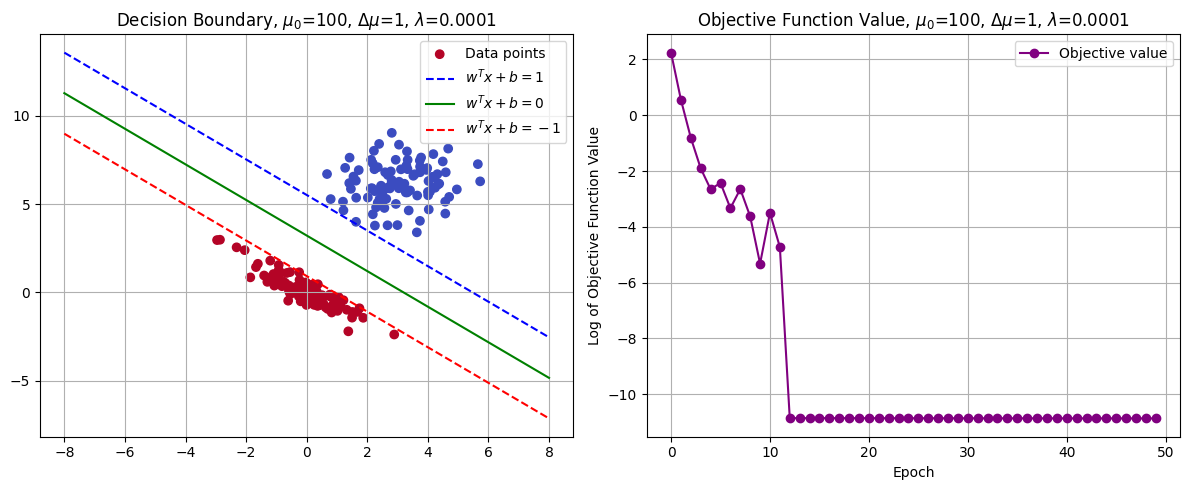

[-0.4388633 -0.4350817] 1.4015223948992233


In [48]:
# Example
x, y = create_dataset(100)
w, b, results = SGD(x, y, mu=100, mu_increase=1, lamb=1e-4, verbose=False, show_graph=True)
print(w, b)

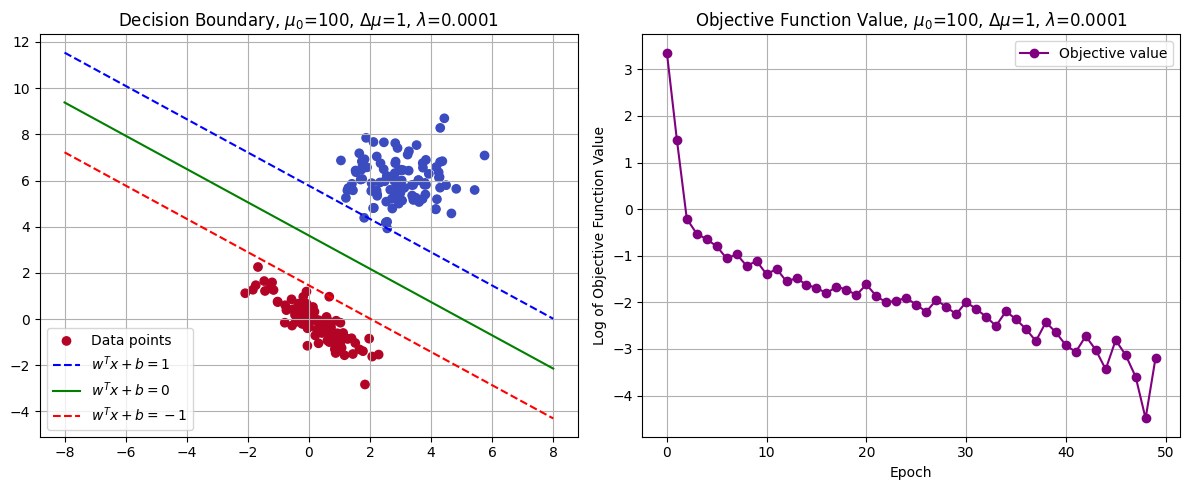

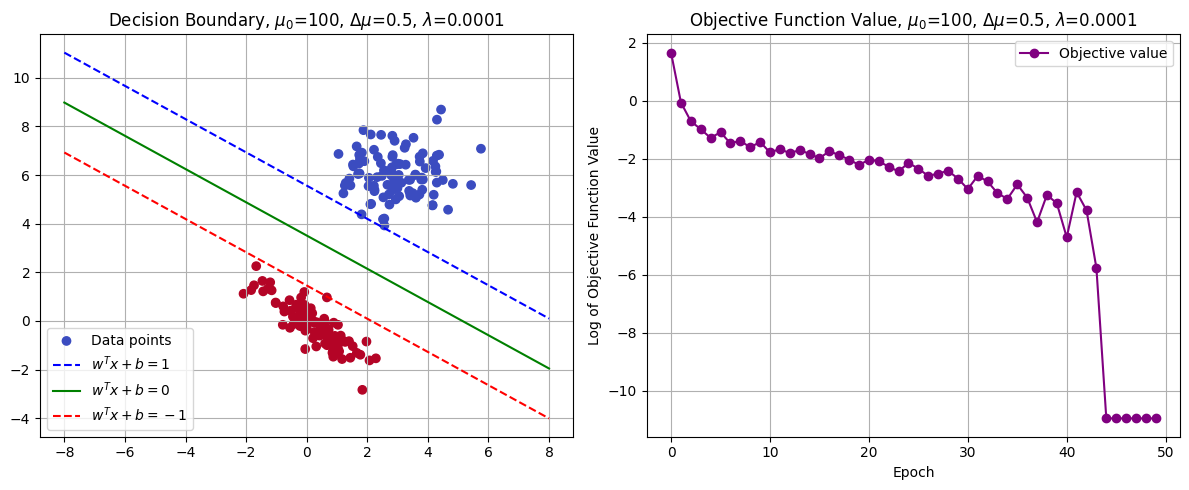

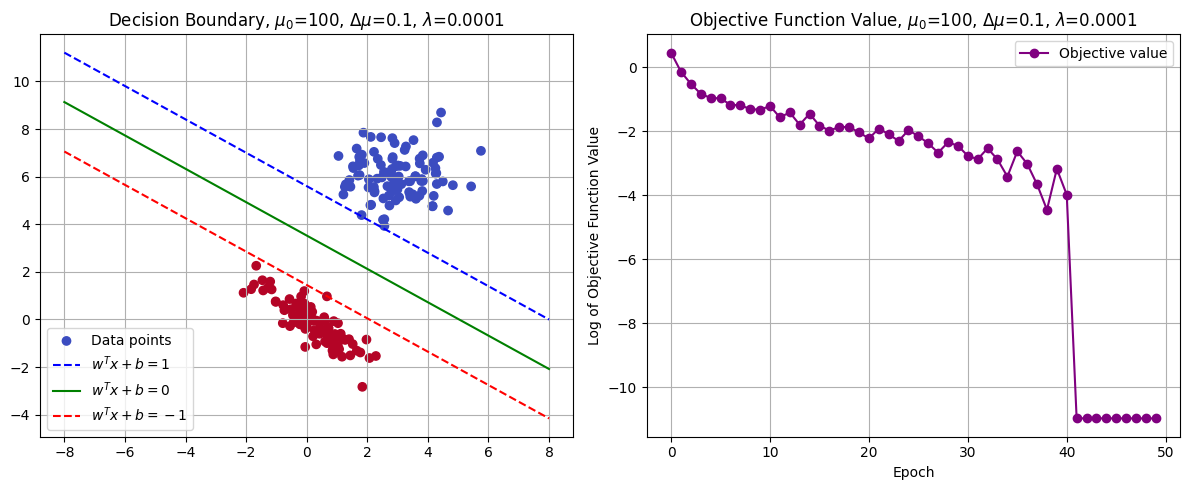

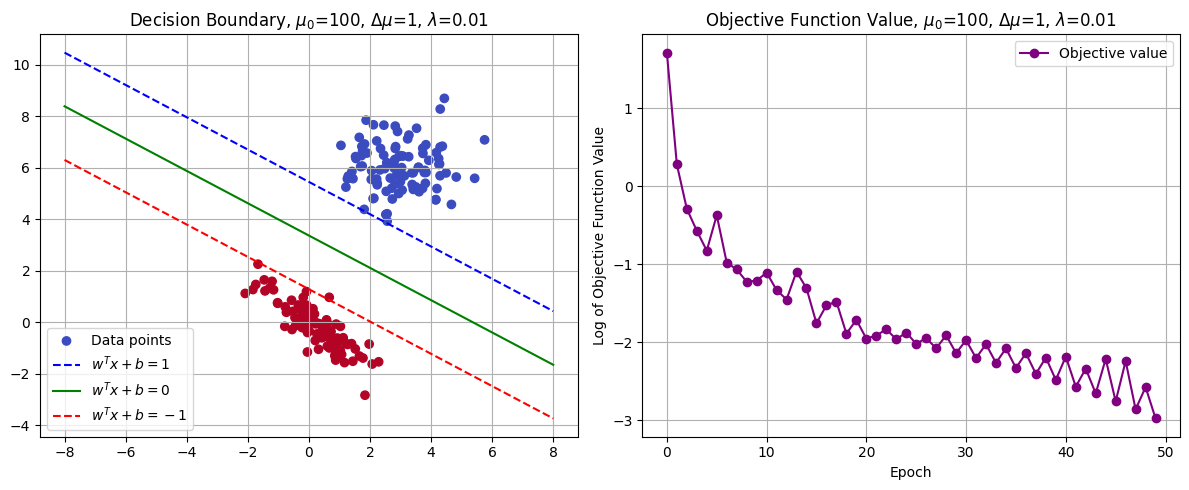

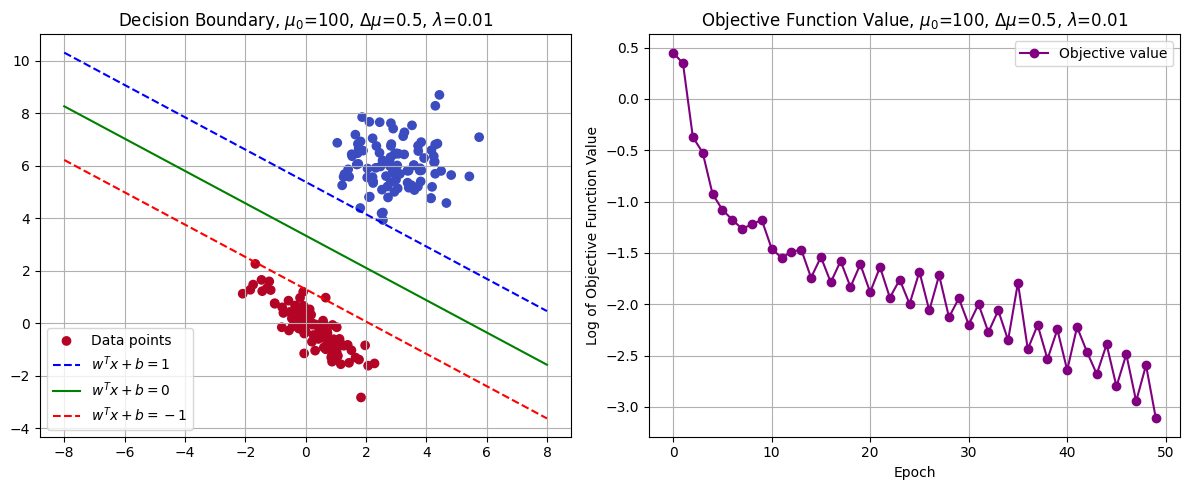

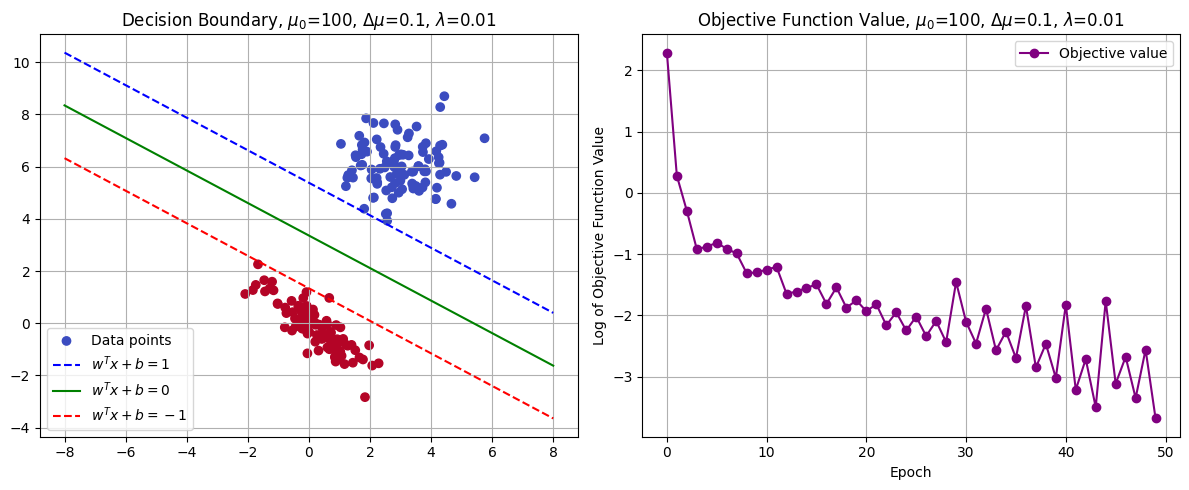

In [29]:
# Let's try with different parameters
x, y = create_dataset(100)
for lamb in [1e-4, 1e-2]:
  for mu_increase in [1, 0.5, 0.1]:
    w, b, results = SGD(x, y, mu=100, mu_increase=mu_increase, lamb=lamb, verbose=False, show_graph=True)

**Answer:**

In all instances the code converged to a good result, sometimes faster, sometimes slower. For all the experiments we used the same dataset and 50 epochs.

The convergence behavior varied with λ, for the smaller value λ = 0.0001, the method converged quickly and smoothly, whereas with the larger value λ = 0.01, we can see irregularities and some oscillatory behavior during convergence.

### 2. Perform some experiments with the mini-batch. You may try different number of samples to construct the mini-batches, e.g. 10 or 50 samples. In order to simplify the problem and be able to perform comparisons between the stochastic and minibatch, take a number of samples of 200 (100 at each class, as performed in the previous lab) and mini-batches with a size that of 10, 20 or 50, for instance. After each epoch you perform a shuffle of the samples and construct again the mini-batches.

In [30]:
# Stochastic Gradient Descend with minibatches
def SGD_minibatch(x, y, batch_size, mu=100, mu_increase=1, lamb=1e-4, max_epochs=50, verbose=False, show_graph=False):
  mu_0 = mu
  # Random initialization
  w = np.random.rand(x.shape[1])
  b = np.random.rand(1)[0]
  results = []
  n = x.shape[0]
  n_batch = n // batch_size

  for epoch in range(max_epochs):
    # Shuffle the data
    perm = np.random.permutation(n)
    x = x[perm, :]
    y = y[perm]

    for i in range(n_batch):
      # Reconstruct minibatches
      x_mini = x[i*batch_size:(i+1)*batch_size, :]
      y_mini = y[i*batch_size:(i+1)*batch_size]
      w_sum = np.zeros(w.shape)
      b_sum = 0
      for i in range(batch_size):
        if y_mini[i] * (w.T.dot(x_mini[i,:]) + b) < 1:
          w_sum -= y_mini[i] * x_mini[i,:]
          b_sum -= y_mini[i]
      # Update w and b
      w += -1 / mu * (lamb * w + w_sum)
      b += -1 / mu * b_sum

    mu += mu_increase
    results.append(np.log(f(x, y, w, b, lamb)))
    if verbose:
      print(f"Epoch {epoch + 1}/{max_epochs} - Loss: {results[-1]}")

  if show_graph:
    print(rf"SGD with batch_size={batch_size}, mu_0={mu_0}, mu_increase={mu_increase}, lambda={lamb}")
    show(x, y, w, b, results)
  return w, b, results

SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=0.0001


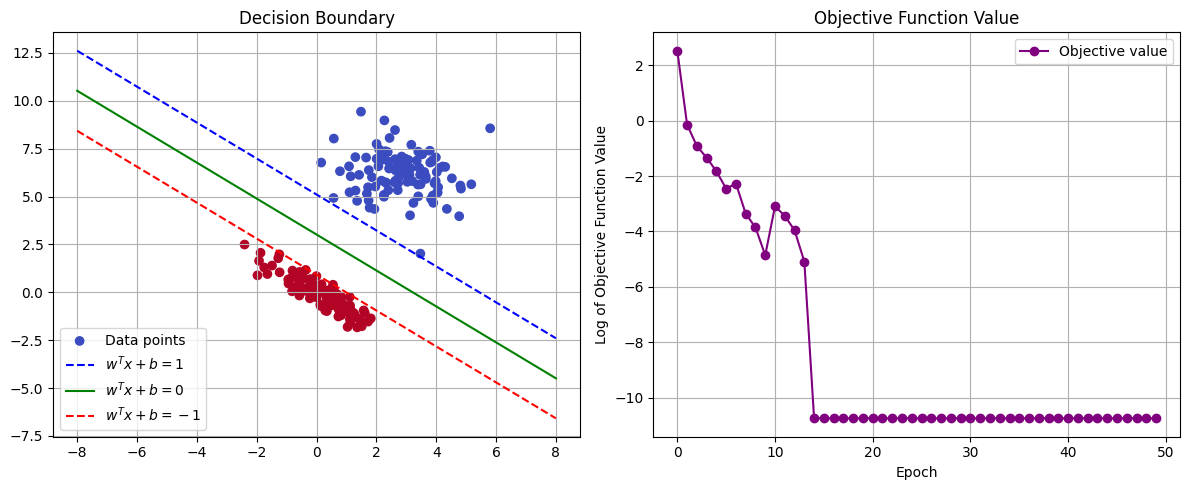

SGD with batch_size=20, mu_0=100, mu_increase=1, lambda=0.0001


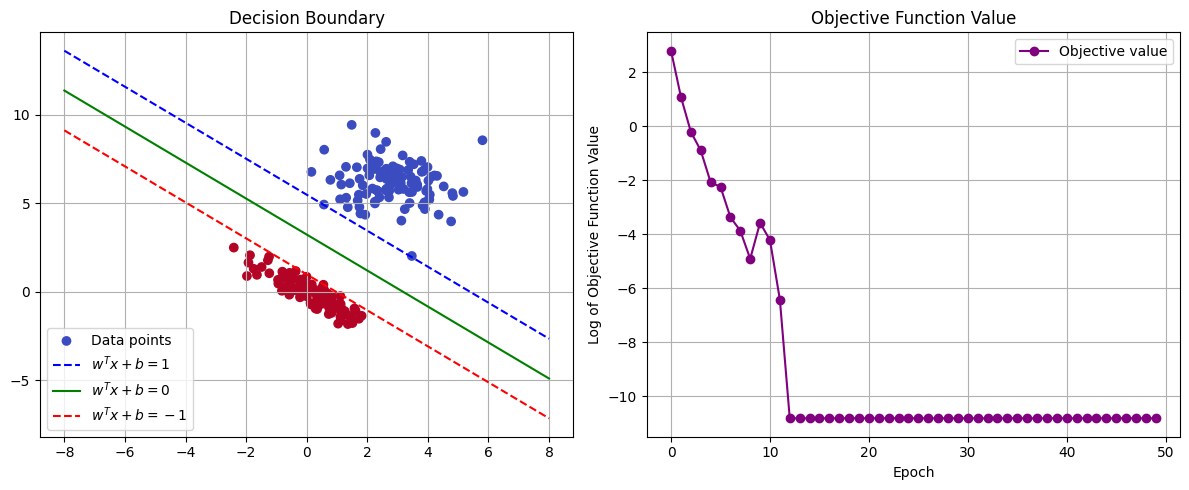

SGD with batch_size=50, mu_0=100, mu_increase=1, lambda=0.0001


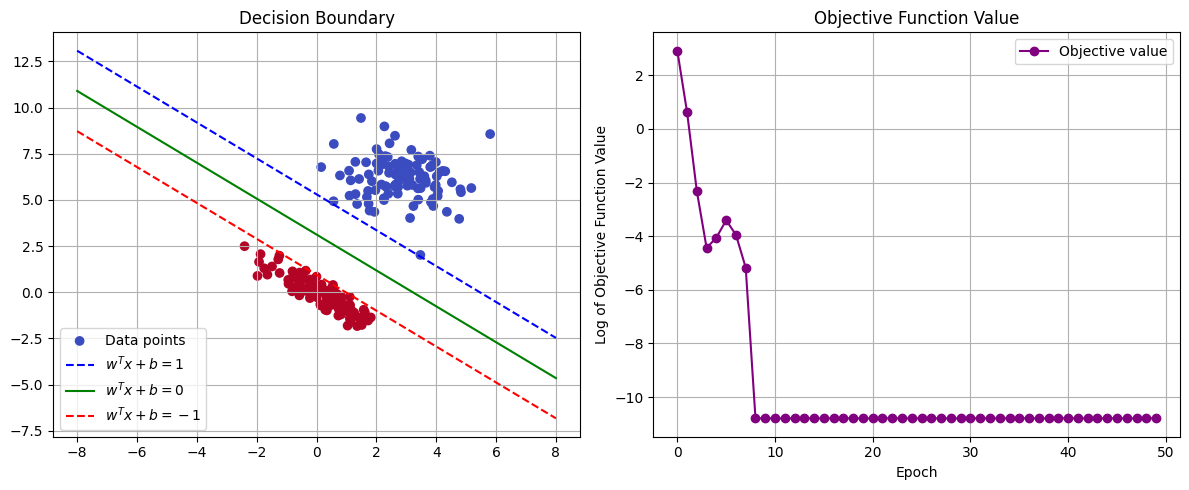

SGD with batch_size=10, mu_0=100, mu_increase=0.5, lambda=0.0001


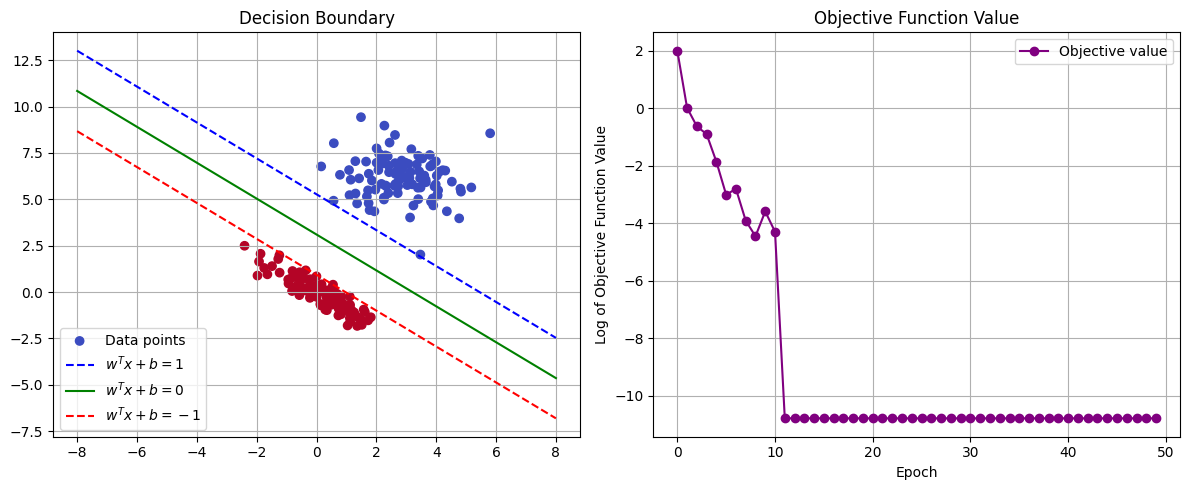

SGD with batch_size=20, mu_0=100, mu_increase=0.5, lambda=0.0001


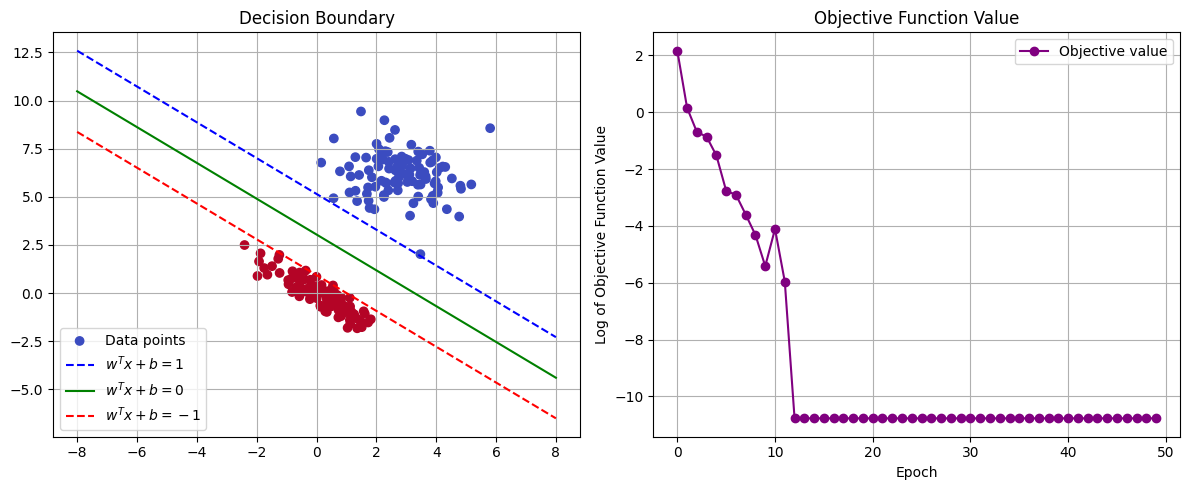

SGD with batch_size=50, mu_0=100, mu_increase=0.5, lambda=0.0001


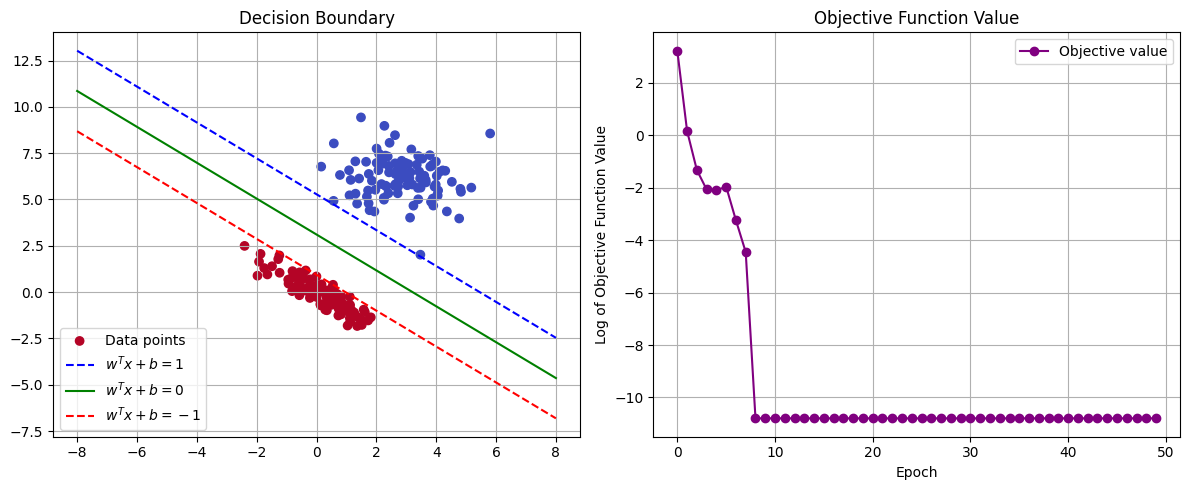

SGD with batch_size=10, mu_0=100, mu_increase=0.1, lambda=0.0001


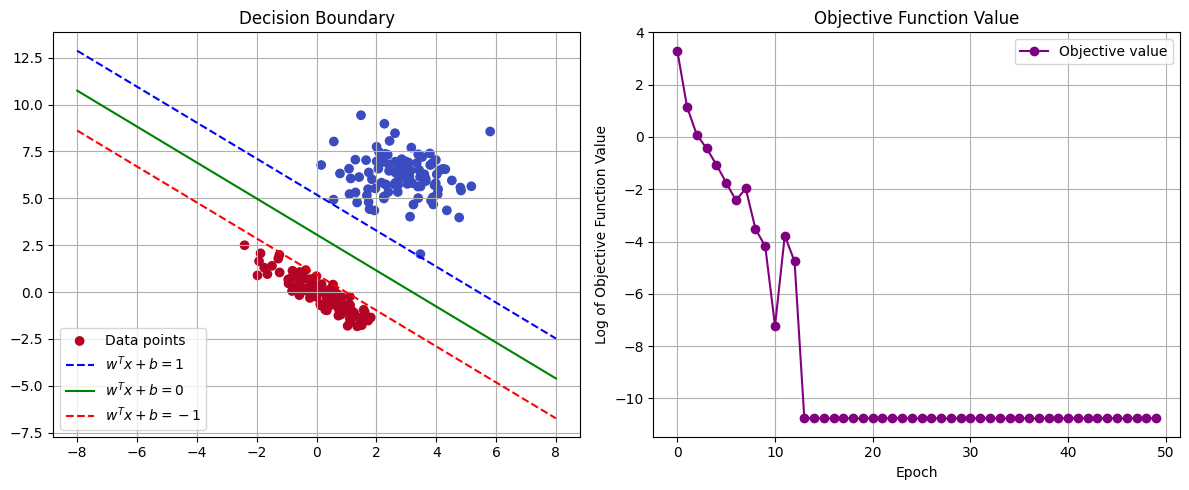

SGD with batch_size=20, mu_0=100, mu_increase=0.1, lambda=0.0001


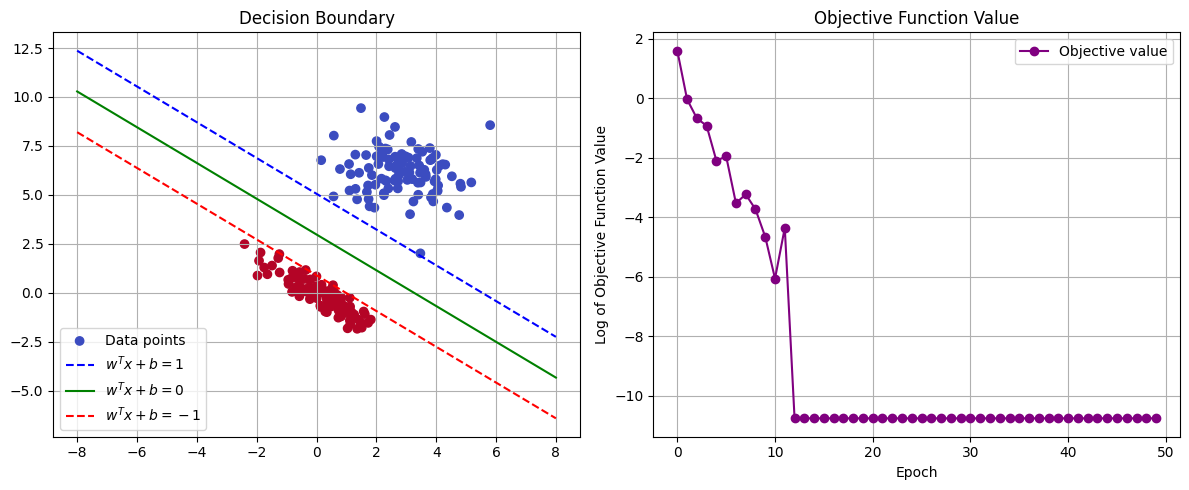

SGD with batch_size=50, mu_0=100, mu_increase=0.1, lambda=0.0001


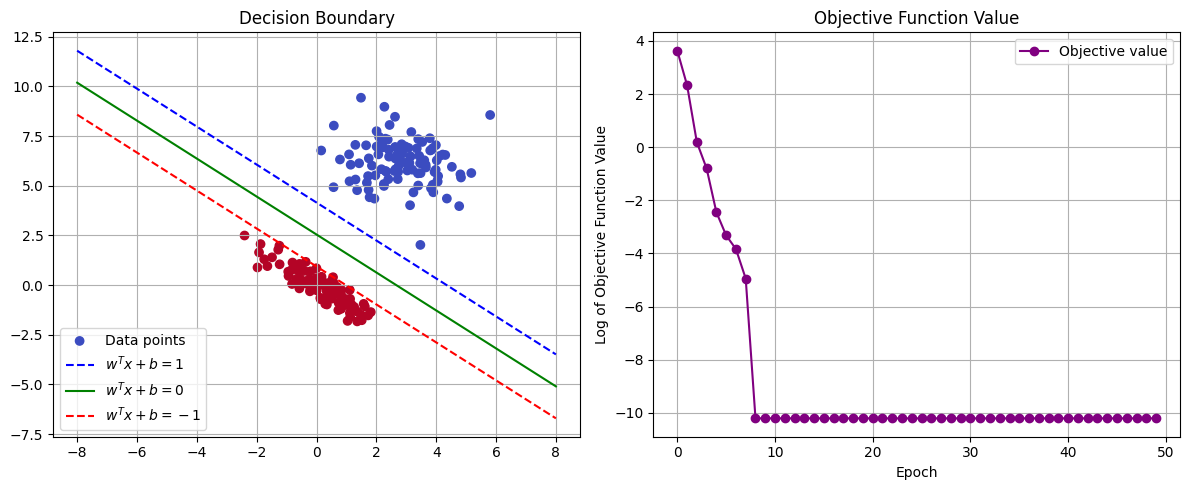

SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=0.01


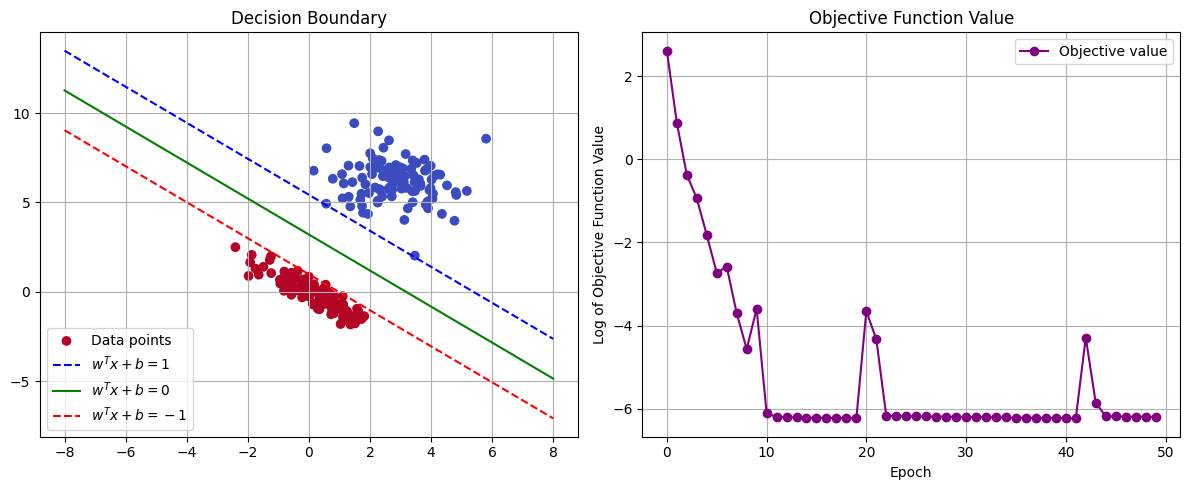

SGD with batch_size=20, mu_0=100, mu_increase=1, lambda=0.01


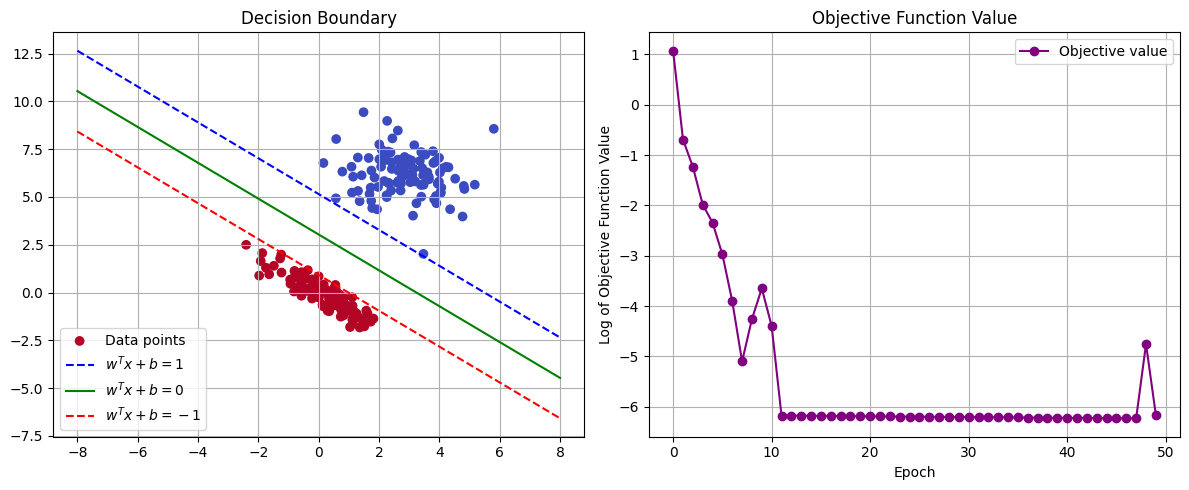

SGD with batch_size=50, mu_0=100, mu_increase=1, lambda=0.01


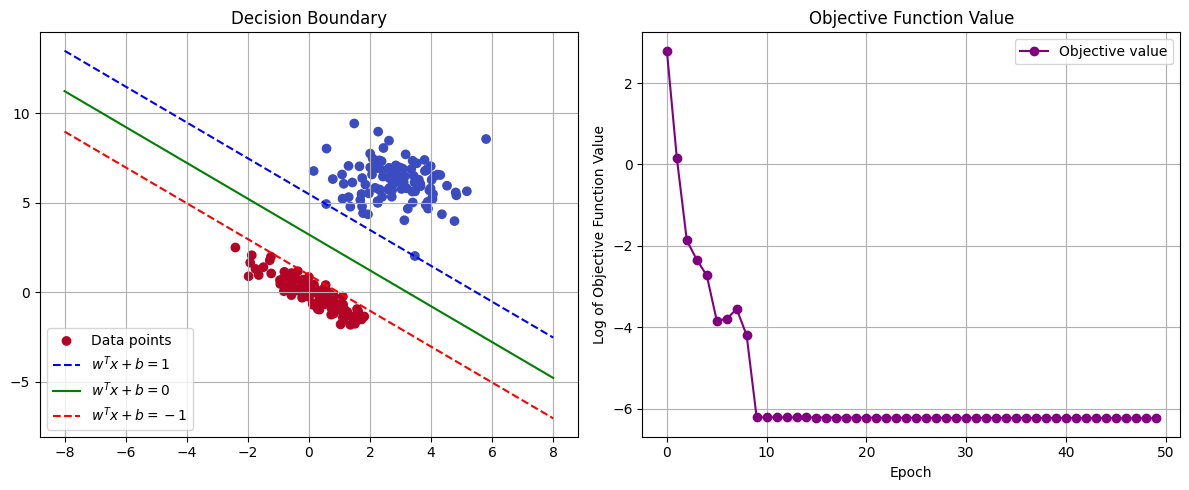

SGD with batch_size=10, mu_0=100, mu_increase=0.5, lambda=0.01


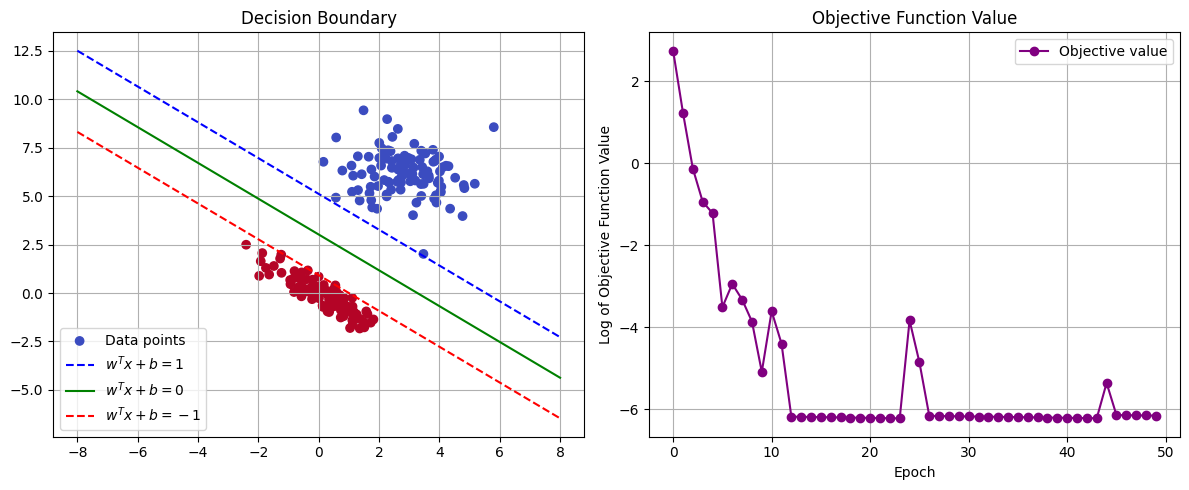

SGD with batch_size=20, mu_0=100, mu_increase=0.5, lambda=0.01


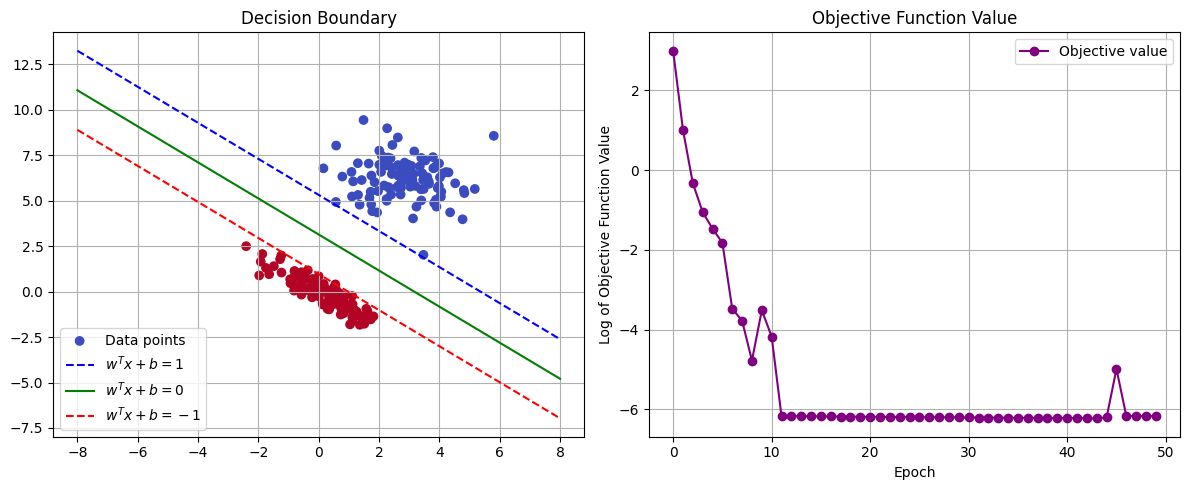

SGD with batch_size=50, mu_0=100, mu_increase=0.5, lambda=0.01


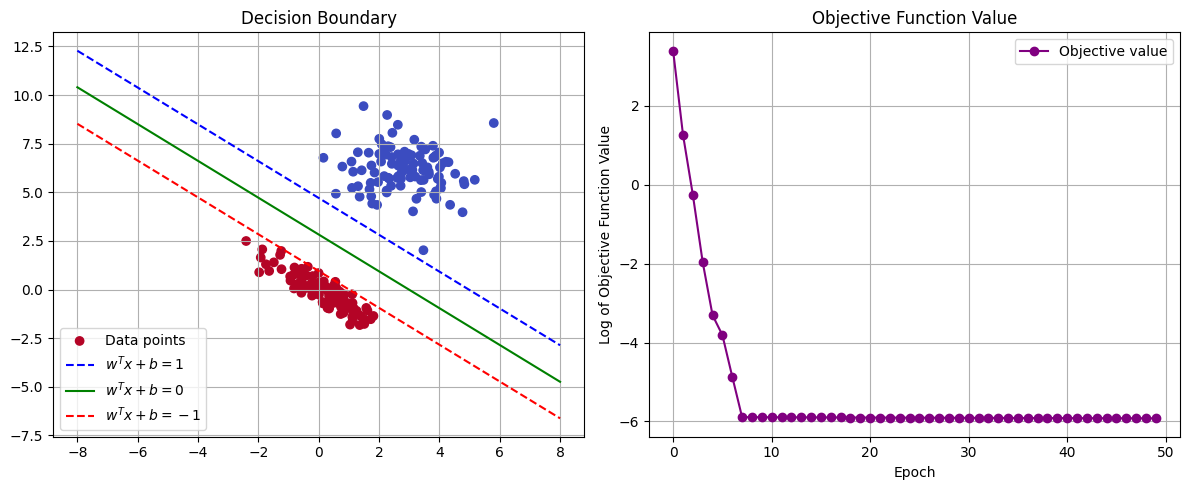

SGD with batch_size=10, mu_0=100, mu_increase=0.1, lambda=0.01


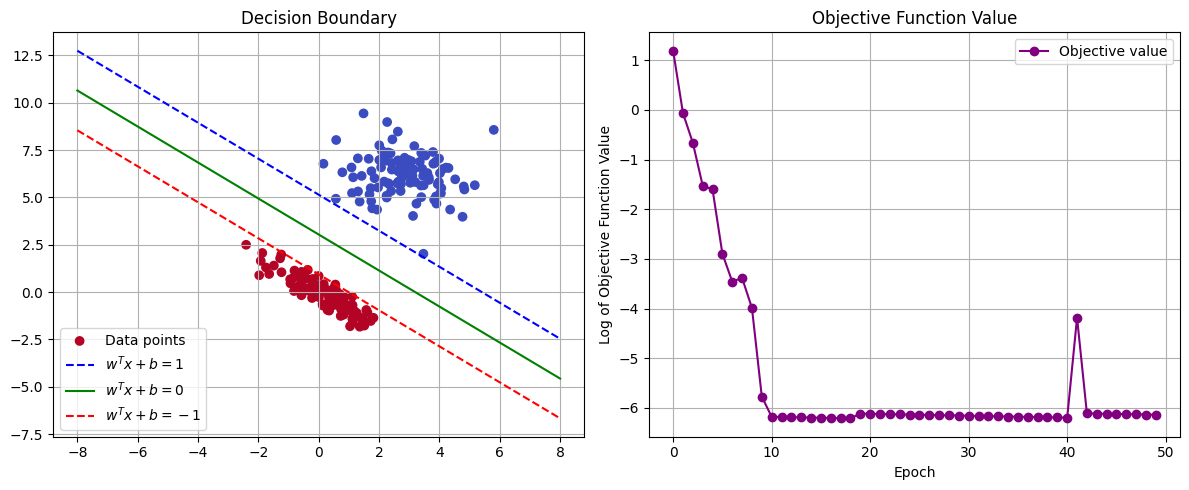

SGD with batch_size=20, mu_0=100, mu_increase=0.1, lambda=0.01


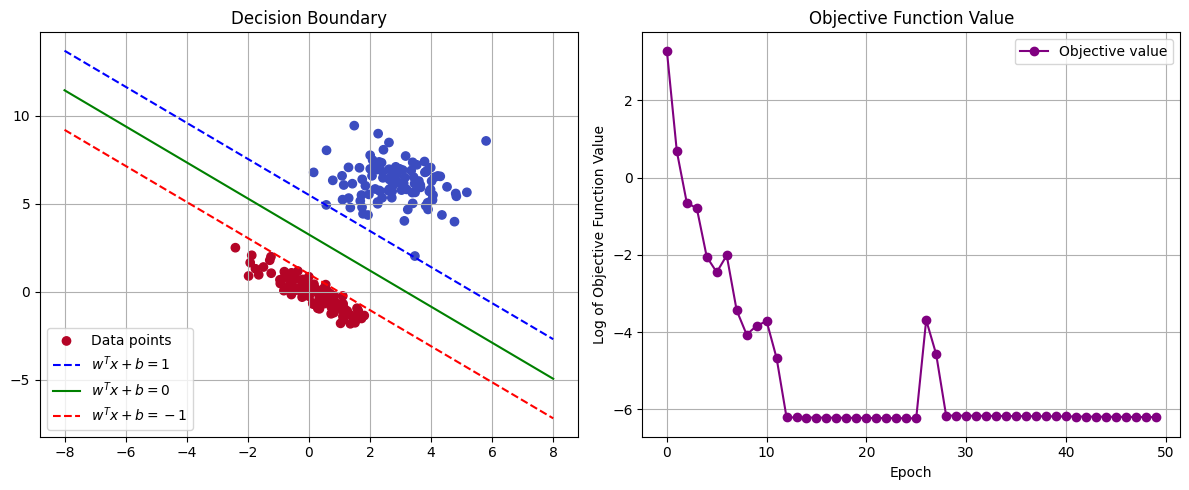

SGD with batch_size=50, mu_0=100, mu_increase=0.1, lambda=0.01


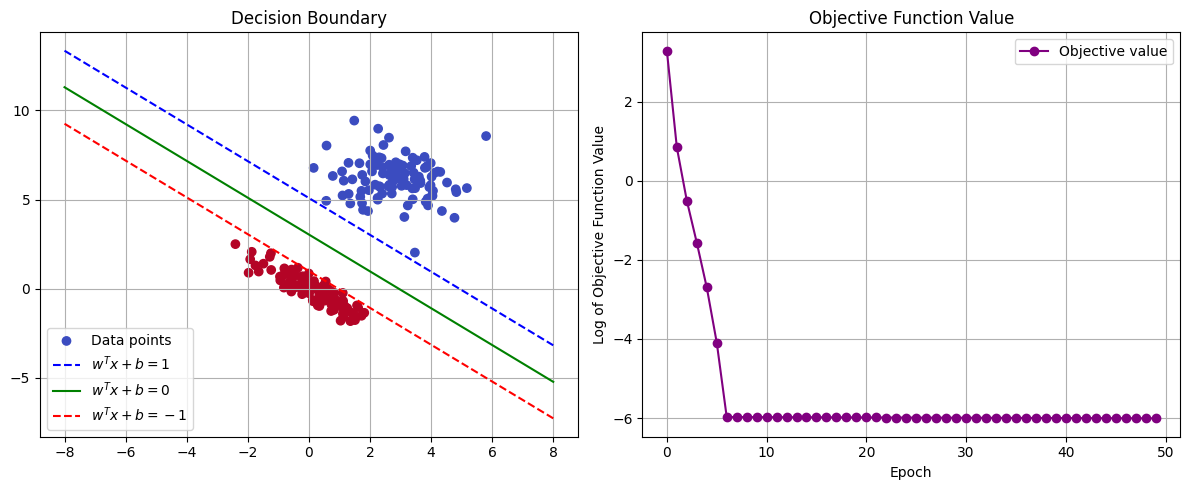

In [31]:
x, y = create_dataset(100)
for lamb in [1e-4, 1e-2]:
  for mu_increase in [1, 0.5, 0.1]:
    for batch_size in [10, 20, 50]:
      w, b, results = SGD_minibatch(x, y, batch_size=batch_size, mu=100, mu_increase=mu_increase, lamb=lamb, show_graph=True)

**Answer:**

We repeated the experiments from the previous exercise using three different batch sizes: 10, 20, 50.

Upon analyzing the results, we observed that the convergence speed of the method increases as the batch size becomes larger. For a batch size of 10, the method converges the slowest, while for a batch size of 50, it converges the fastest. However, with a batch size of 50, the decision margins appear slightly inaccurate—they are not perfectly aligned with the data, leaving some free space that could be better optimized.

An interesting observation is that the Objective Function Value occasionally exhibits significant spikes, but far less often than in the previous cases. This behavior is likely due to the smaller batch sizes used during optimization. While these spikes may seem counterintuitive at first, they indicate that the method is escaping local minima and progressing toward the global minimum, which is ultimately advantageous. With classical SGD, there were too many, as the samples were very different between each other. It is better to use a minibatch because it brings some consistency.

### 3. Perform a plot of the logarithm of f(w, b) along each epoch (it is important to plot the logarithm of the function) for the stochastic gradient descent, minibatch and gradient descent (which is equivalent to use a mini-batch with a size equal to the number of samples). This allows you to see how fast each of the methods approaches the optimal solution and perform a comparison between the different experiments you have done.

In [67]:
# Gradient Descend (not stochastic)
def GD(x, y, mu=100, mu_increase=1, lamb=1e-4, max_epochs=50, verbose=False, show_graph=False):
  mu_0 = mu
  # Random initialization
  w = np.random.rand(x.shape[1])
  b = np.random.rand(1)[0]
  results = []
  n = x.shape[0]
  batch_size = n
  n_batch = n // batch_size

  for epoch in range(max_epochs):
    # Shuffle the data
    perm = np.random.permutation(n)
    x = x[perm, :]
    y = y[perm]

    for i in range(n_batch):
      # Reconstruct minibatches
      x_mini = x[i*batch_size:(i+1)*batch_size, :]
      y_mini = y[i*batch_size:(i+1)*batch_size]
      w_sum = np.zeros(w.shape)
      b_sum = 0
      for i in range(batch_size):
        if y_mini[i] * (w.T.dot(x_mini[i,:]) + b) <= 1:
          w_sum -= y_mini[i] * x_mini[i,:]
          b_sum -= y_mini[i]
      # Update w and b
      w += -(1 / mu) * (lamb * w + w_sum)
      b += -(1 / mu) * b_sum

    mu += mu_increase
    results.append(np.log(f(x, y, w, b, lamb)))
    if verbose:
      print(f"Epoch {epoch + 1}/{max_epochs} - Loss: {results[-1]}")

  if show_graph:
    print(rf"GD, mu_0={mu_0}, mu_increase={mu_increase}, lambda={lamb}")
    show(x, y, w, b, results)
  return w, b, results

GD, mu_0=100, mu_increase=1, lambda=0.0001


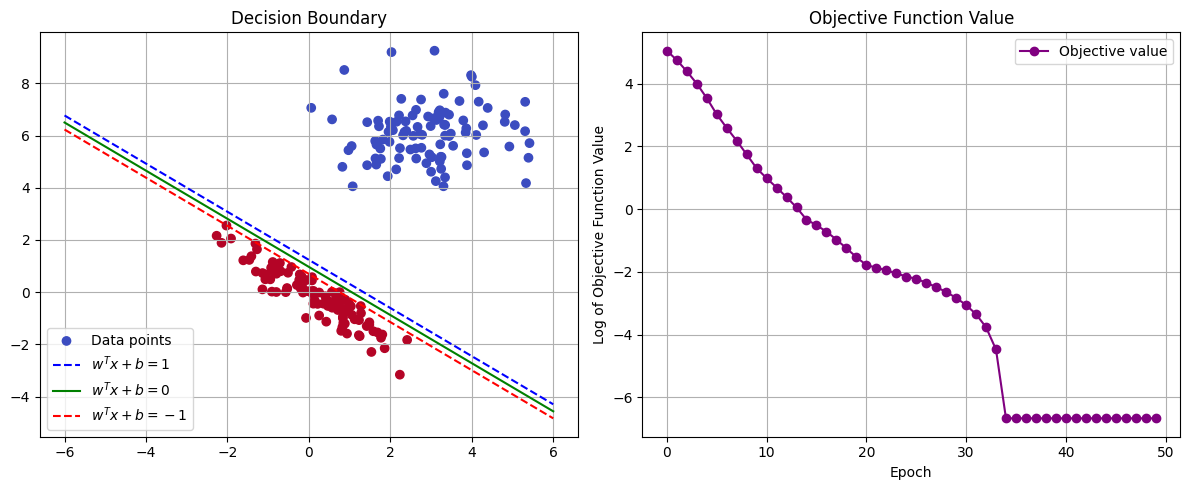

GD, mu_0=100, mu_increase=0.5, lambda=0.0001


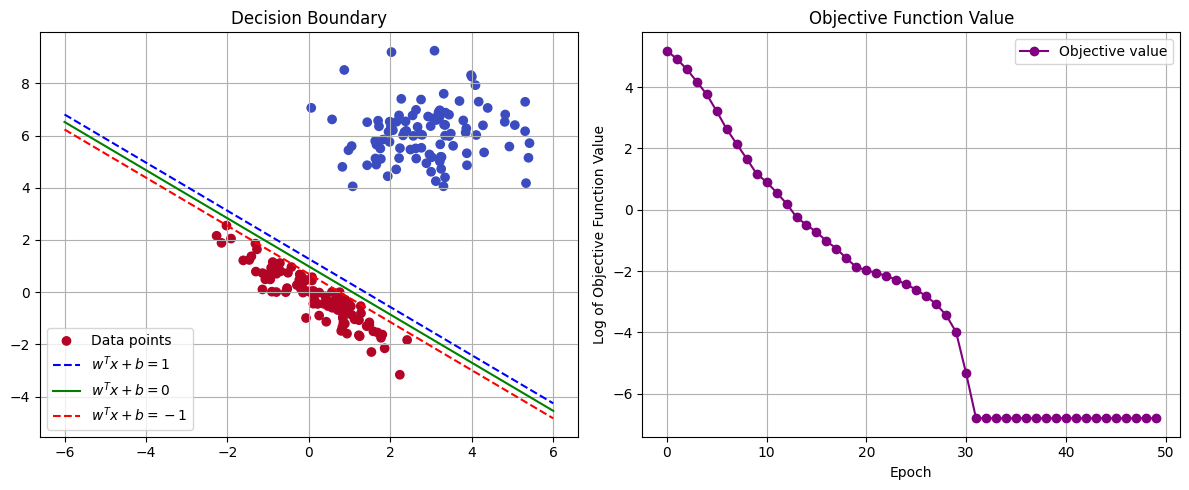

GD, mu_0=100, mu_increase=0.1, lambda=0.0001


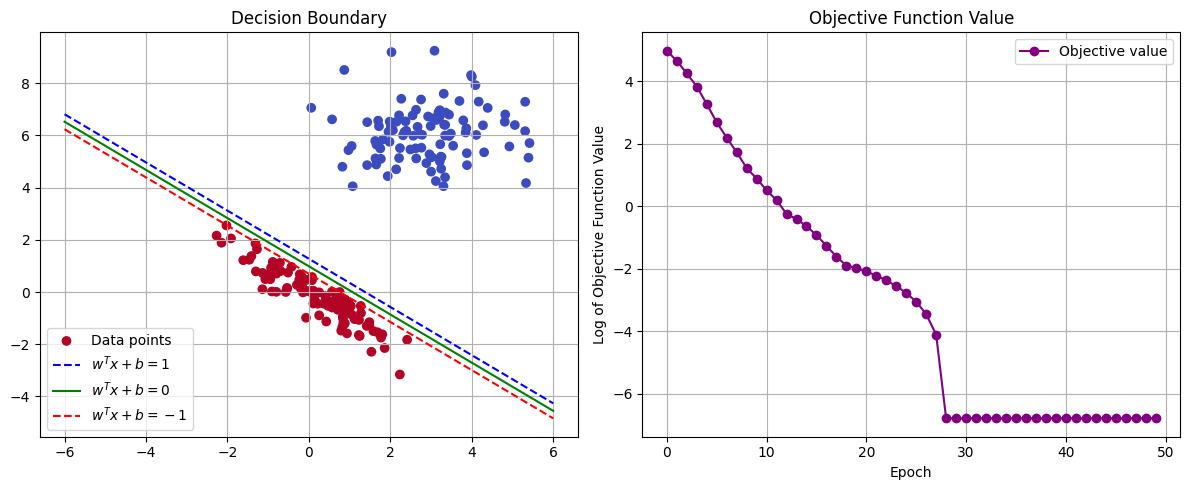

GD, mu_0=100, mu_increase=1, lambda=0.01


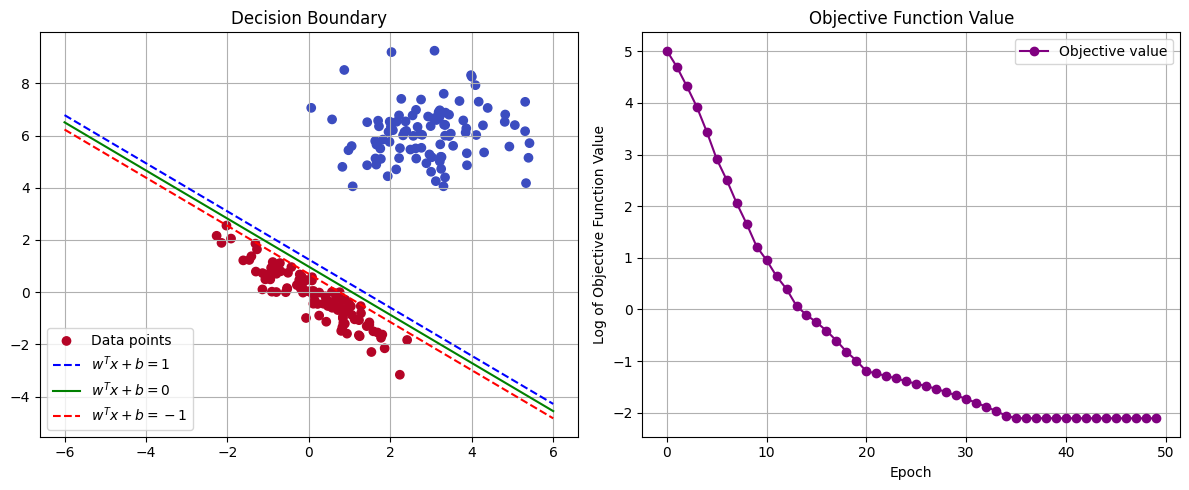

GD, mu_0=100, mu_increase=0.5, lambda=0.01


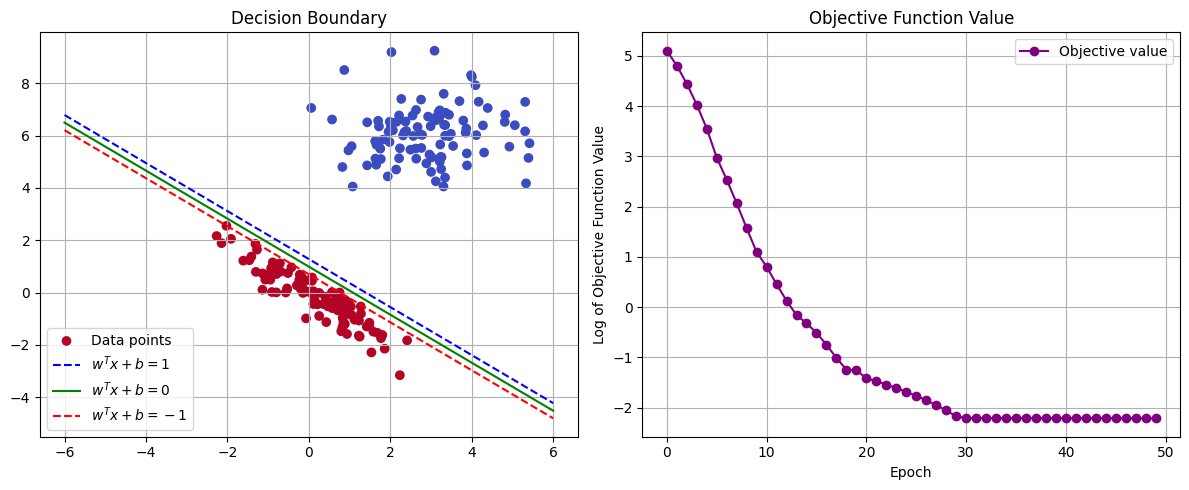

GD, mu_0=100, mu_increase=0.1, lambda=0.01


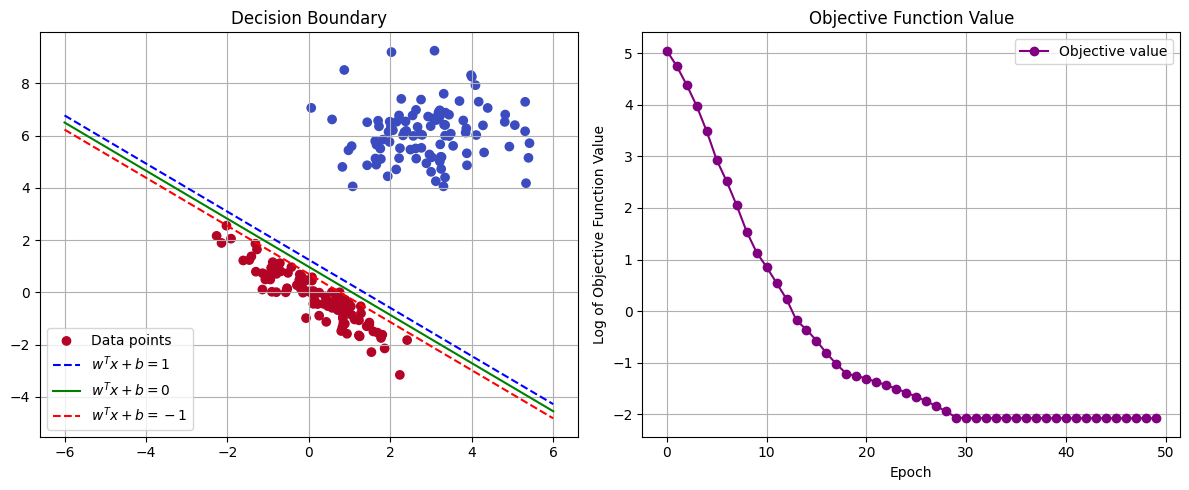

In [73]:
x, y = create_dataset(100)
for lamb in [1e-4, 1e-2]:
  for mu_increase in [1, 0.5, 0.1]:
    w, b, results = GD(x, y, mu=100, mu_increase=mu_increase, lamb=lamb, show_graph=True)

We recreated the same tests as before with the GD (all data in one batch) and the results were not good. Our proposal for improvement is to change the mu value. As the batch is much larger, the sums get very big and we need to reduce them with a smaller. Let's test it.

GD, mu_0=100, mu_increase=1, lambda=0.0001


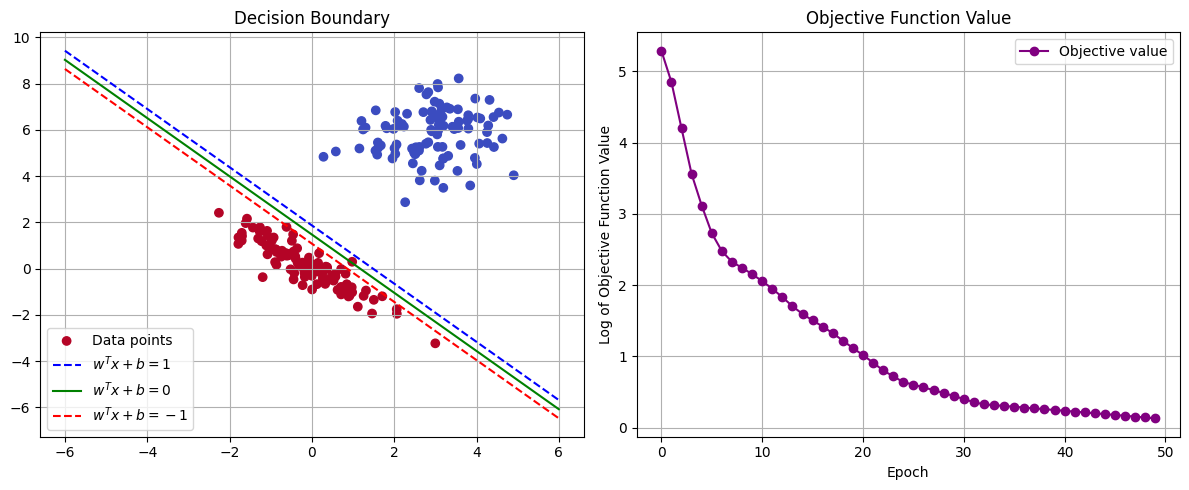

GD, mu_0=200, mu_increase=1, lambda=0.0001


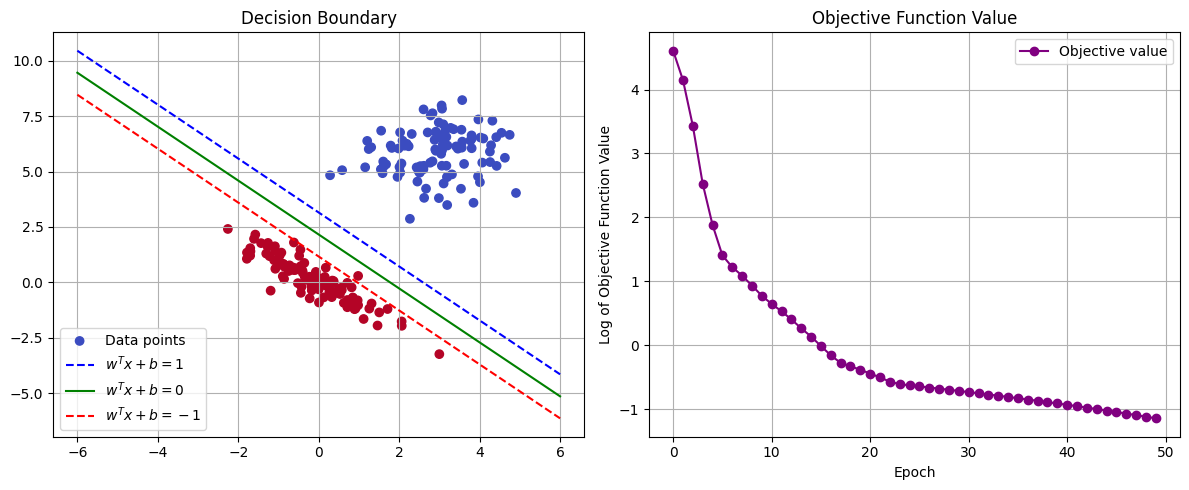

GD, mu_0=300, mu_increase=1, lambda=0.0001


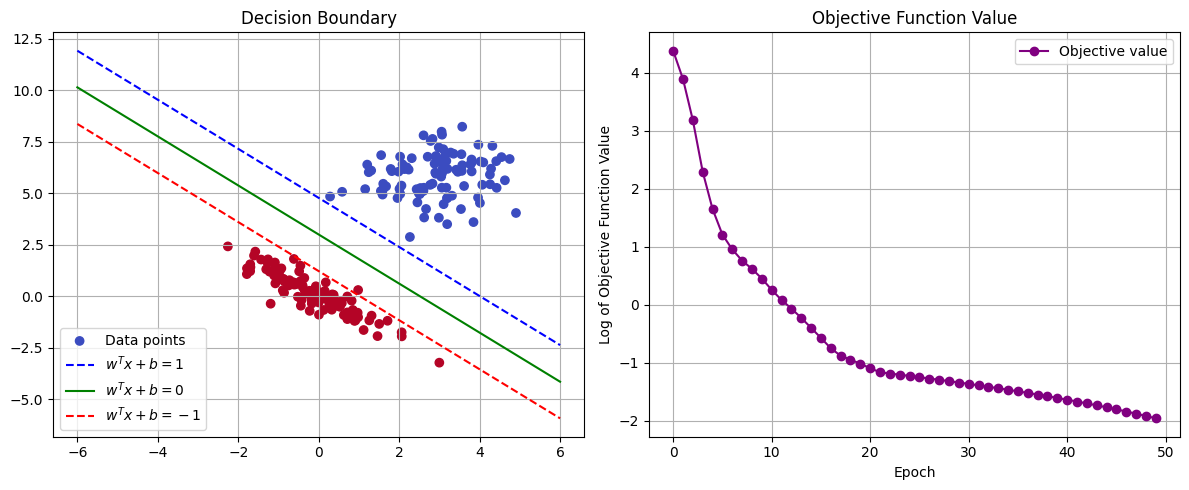

GD, mu_0=400, mu_increase=1, lambda=0.0001


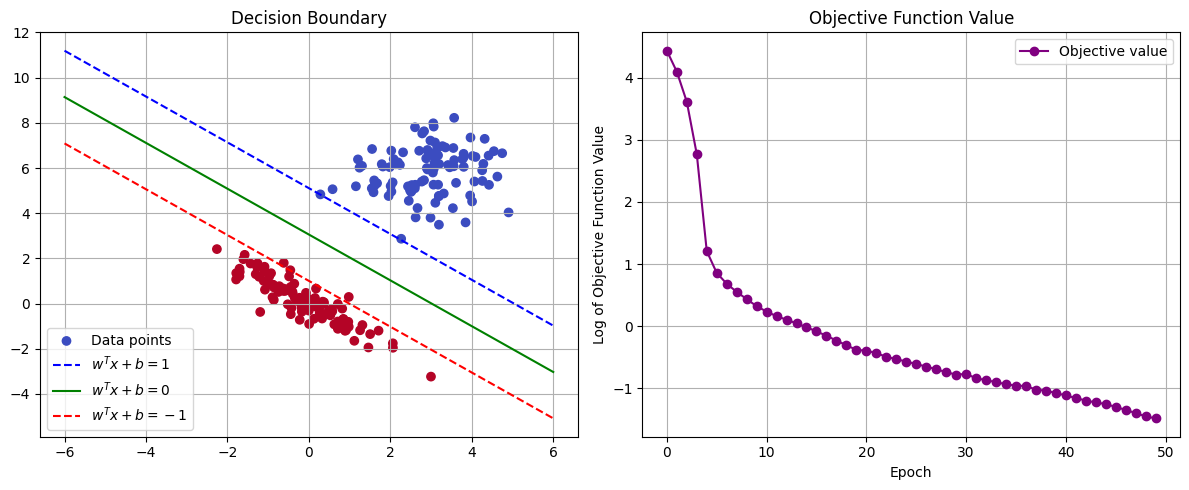

GD, mu_0=500, mu_increase=1, lambda=0.0001


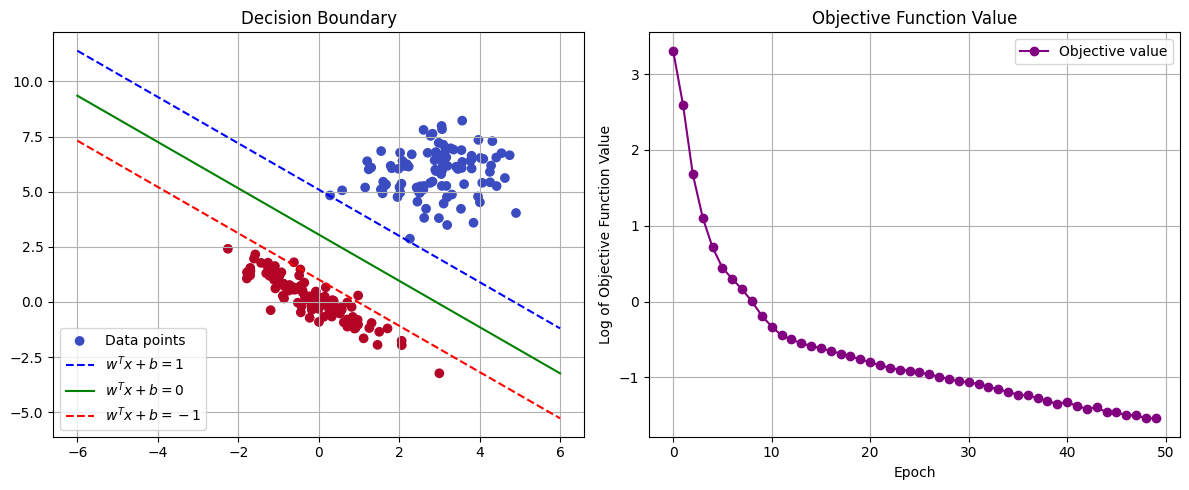

In [75]:
# Let's try different starting mu values
x, y = create_dataset(100)
for mu in [100, 200, 300, 400, 500]:
  w, b, results = GD(x, y, mu=mu, mu_increase=1, lamb=1e-4, show_graph=True)

As we can see, the Decision Boundaries are much better, filling the whole space between the two sets and not just aglomerating near the red set. However, some individual points are wrongly located inside the lines. On another hand, the Objective Function Value does not change much, it does not reach very good results. Let's compare now all the methods we have seen in the same conditions.

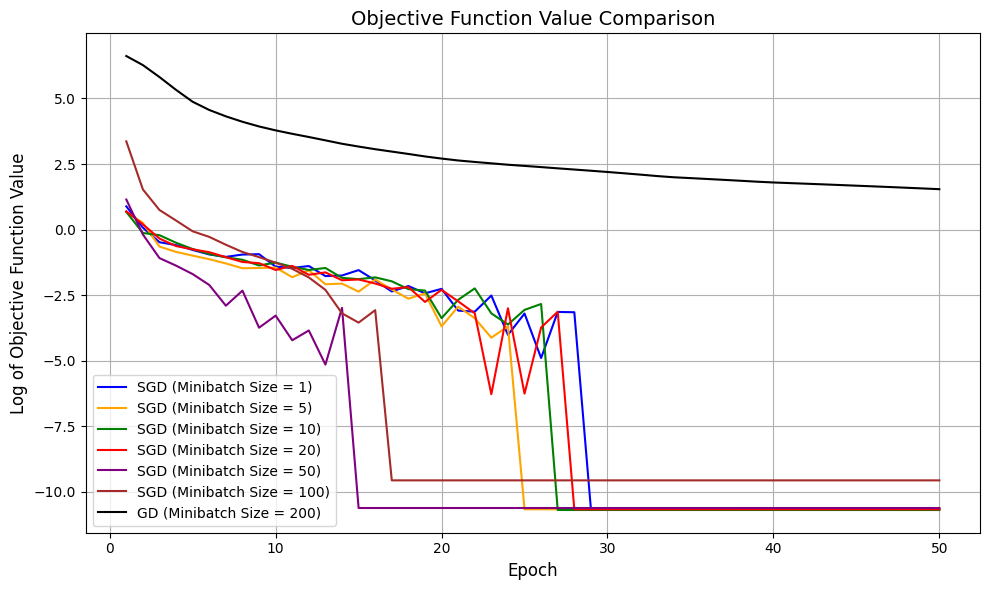

In [78]:
# Let's calculate one of each together to compare the results

x, y = create_dataset(200)
w_sgd, b_sgd, r_sgd = SGD(x, y)
w_5, b_5, r_5 = SGD_minibatch(x, y, 5)
w_10, b_10, r_10 = SGD_minibatch(x, y, 10)
w_20, b_20, r_20 = SGD_minibatch(x, y, 20)
w_50, b_50, r_50 = SGD_minibatch(x, y, 50)
w_100, b_100, r_100 = SGD_minibatch(x, y, 100)
w_gd, b_gd, r_gd = GD(x, y)

epochs = range(1, len(r_sgd) + 1)

# Plot each method's results
plt.figure(figsize=(10, 6))
plt.plot(epochs, r_sgd, label='SGD (Minibatch Size = 1)', linestyle='-', color='blue')
plt.plot(epochs, r_5, label='SGD (Minibatch Size = 5)', linestyle='-', color='orange')
plt.plot(epochs, r_10, label='SGD (Minibatch Size = 10)', linestyle='-', color='green')
plt.plot(epochs, r_20, label='SGD (Minibatch Size = 20)', linestyle='-', color='red')
plt.plot(epochs, r_50, label='SGD (Minibatch Size = 50)', linestyle='-', color='purple')
plt.plot(epochs, r_100, label='SGD (Minibatch Size = 100)', linestyle='-', color='brown')
plt.plot(epochs, r_gd, label='GD (Minibatch Size = 200)', linestyle='-', color='black')

plt.title("Objective Function Value Comparison", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Log of Objective Function Value", fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

**Answer:**

Looking at the different paths of the Objective function results, we can draw some conlusions. In general, the bigger the batch_size, the faster the convergence. However, if it is too big, it won't converge to the global minimum, it may get stuck in local minima. It is the case for batch_size 100 and Gradient Descent (with batch_size = the full size) in the graphic above. With the GD case being very far away. We would argue that in general it is much better to use a small batch_size.

### Comparison to Practical 5

SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=1


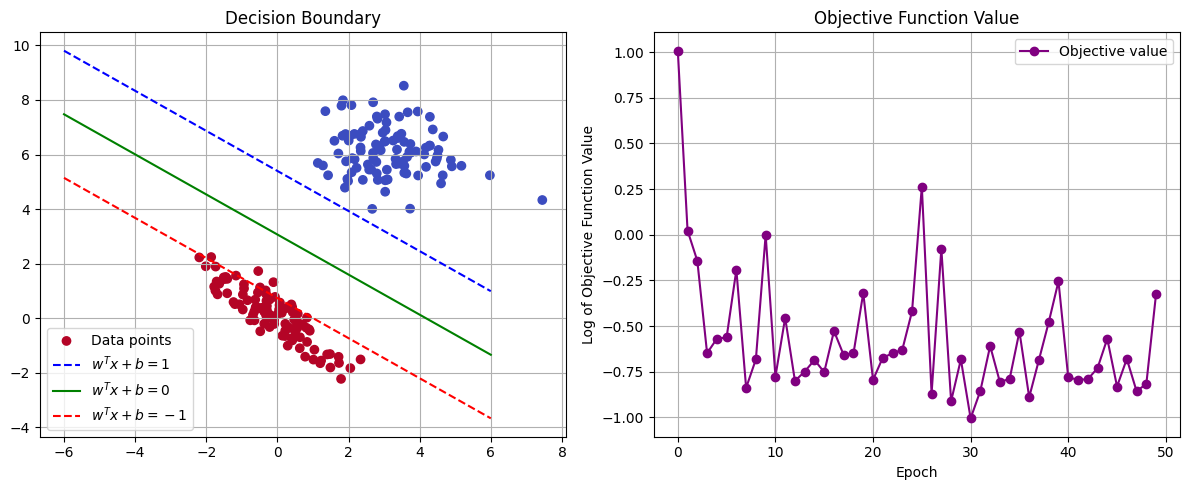

SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=100


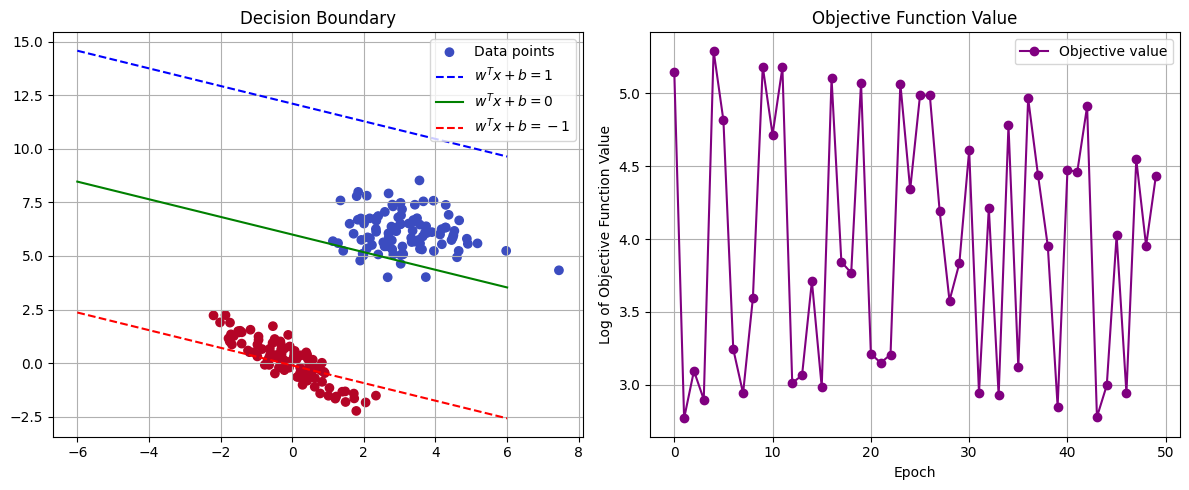

<ipython-input-30-ee32e46fca44>:28: RuntimeWarning: overflow encountered in multiply
  w += -1 / mu * (lamb * w + w_sum)
<ipython-input-30-ee32e46fca44>:28: RuntimeWarning: invalid value encountered in add
  w += -1 / mu * (lamb * w + w_sum)


SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=1000000.0


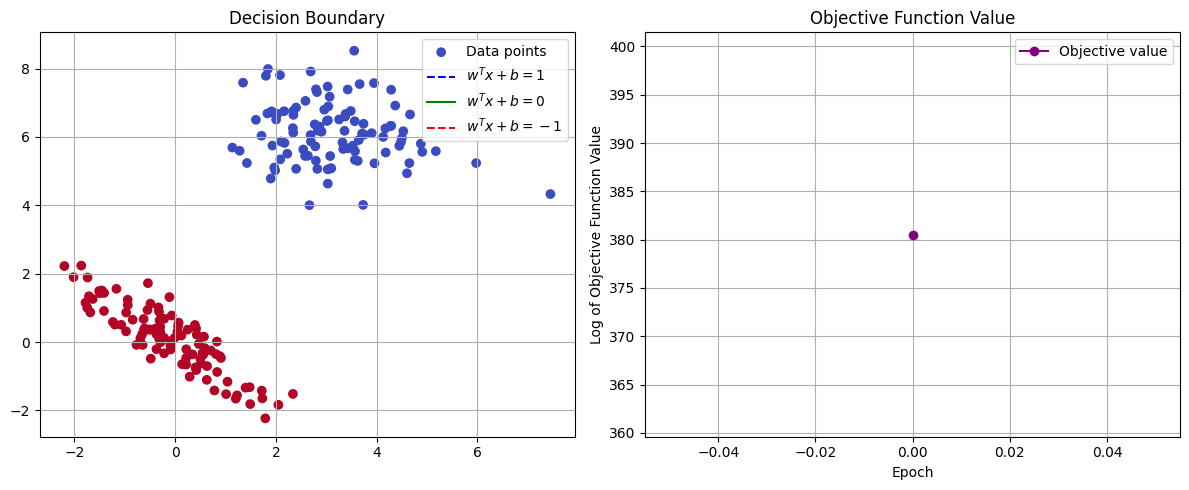

SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=0.001


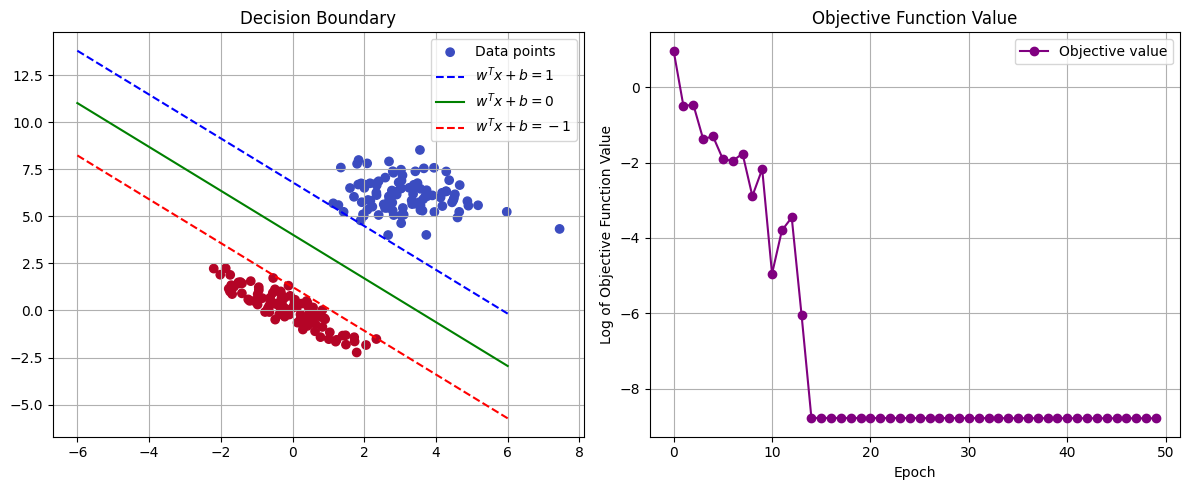

In [82]:
# We will use the same K (lambda in this case) that we used in 5
x, y = create_dataset(100, is_separable=True)
for lamb in [1, 100, 1e6, 1e-3]:
  w, b, results = SGD_minibatch(x, y, batch_size=10, lamb=lamb, show_graph=True)

SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=1


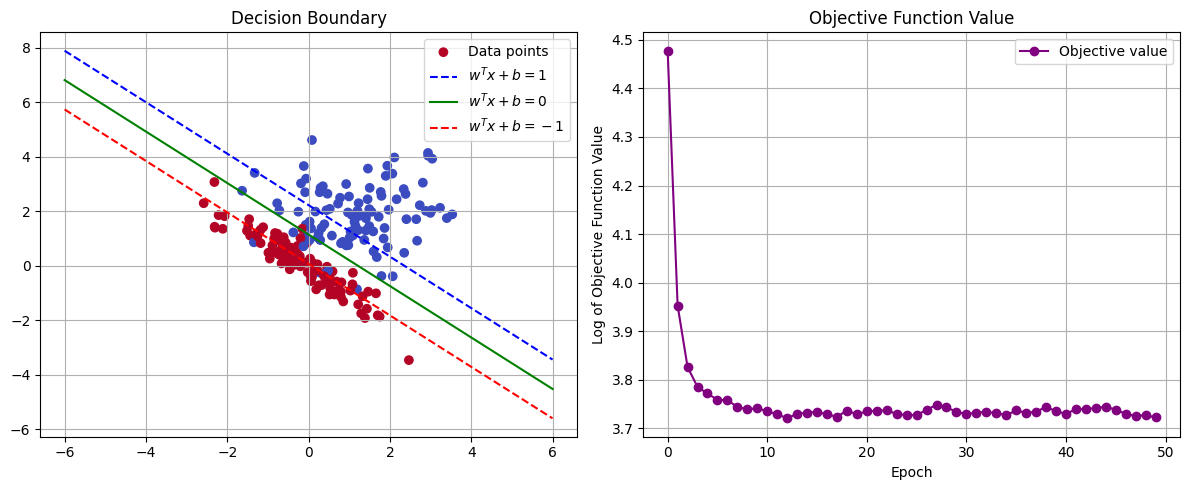

SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=100


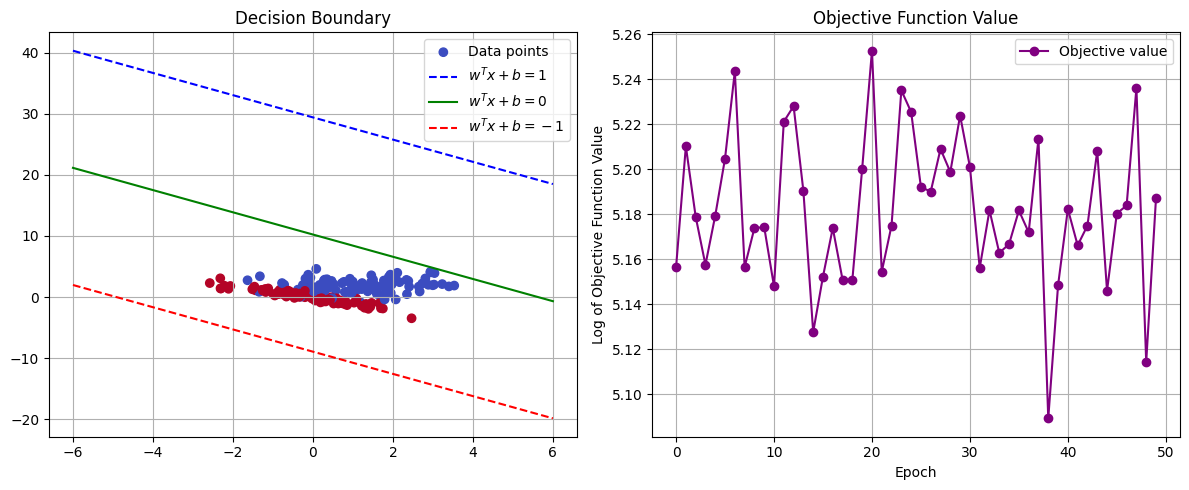

<ipython-input-30-ee32e46fca44>:28: RuntimeWarning: overflow encountered in multiply
  w += -1 / mu * (lamb * w + w_sum)
<ipython-input-30-ee32e46fca44>:28: RuntimeWarning: invalid value encountered in add
  w += -1 / mu * (lamb * w + w_sum)


SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=1000000.0


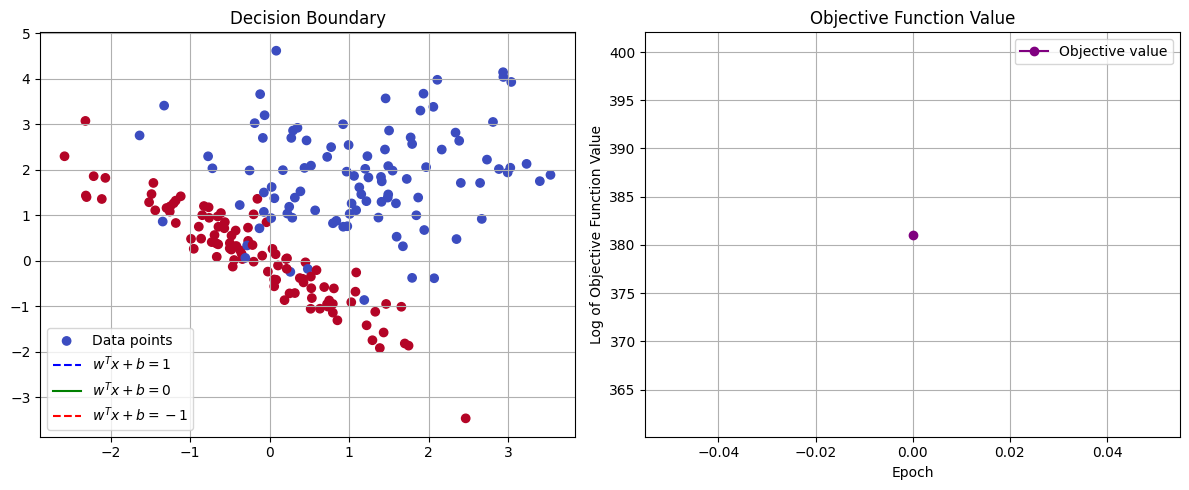

SGD with batch_size=10, mu_0=100, mu_increase=1, lambda=0.001


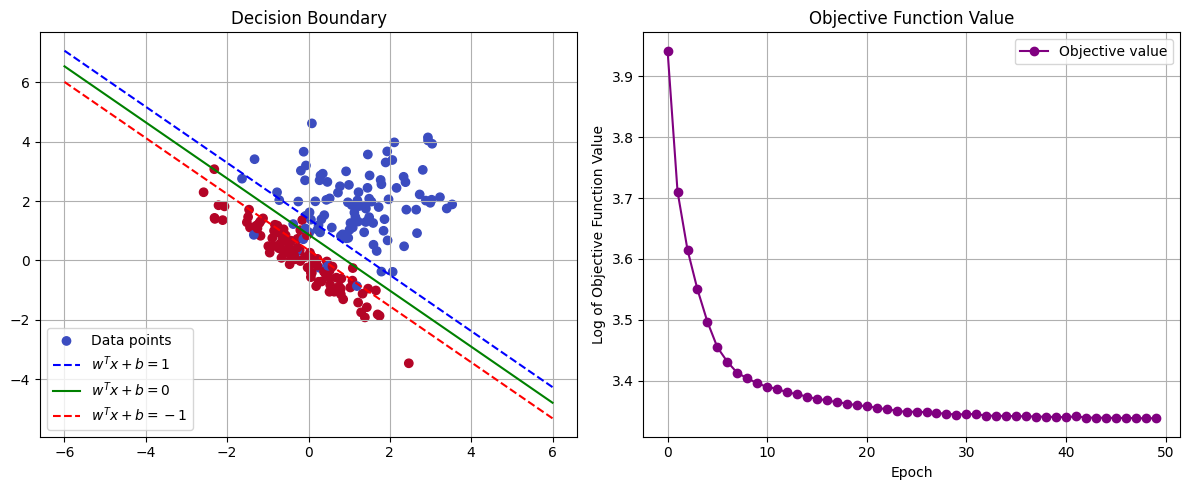

In [81]:
# We will use the same K (lambda in this case) that we used in 5
x, y = create_dataset(100, is_separable=False)
for lamb in [1, 100, 1e6, 1e-3]:
  w, b, results = SGD_minibatch(x, y, batch_size=10, lamb=lamb, show_graph=True)

**Answer:**

We can clearly see that this method performs better with values smaller than 1.  With lambda=1e6, it gave an error. With 1 it can reach an ok result but it oscilates a lot. The best results are with lambda=0.001.

Compared to last practical, we also got some trouble with large K values, and prefered more demure values. In both cases, we were able to reach a good solution that separates optimally the points in both the separable and the non-separable case.